In [1]:
##### Libraries #####
import dotenv
dotenv.load_dotenv(".env")
import os
import time
import utils
import shutil
import argparse
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)
import models_tensorflow.EEGModels
from typing import Literal
from tensorflow.keras import backend
from tensorflow.keras import utils as tf_utils
backend.set_image_data_format("channels_last")
from sklearn.model_selection import train_test_split

import utils
from utils import Metric, plot_confusion_matrix, plot_history
from libs.dataset import BcicIv2aDataset, InnerSpeechDataset

## Load BCIC IV 2a Dataset 

In [2]:
os.environ["DATASET_DIR"] = 'datasets'

In [3]:
dataset = BcicIv2aDataset()  # l_freq=4
inputs, truths = dataset.all_data_and_label

Loading BCIC IV 2a dataset - A09E: 100%|████████| 18/18 [00:23<00:00,  1.29s/it]


In [4]:
inputs.shape

(5184, 22, 257)

In [5]:
truths.shape

(5184, 4)

In [6]:
truths[0]

array([False, False, False,  True])

## Prepare Inputs and Ground Truth Data

### Converting inputs to shape (batch_size, sequence_length, num_features)

In [7]:
inputs = np.transpose(inputs, (0, 2, 1))
print(inputs.shape)

(5184, 257, 22)


In [8]:
# Example function to load dataset (this should be replaced with actual data loading)
def load_dataset():
    x =  inputs #  np.random.rand(100, 22, 257)  # Simulated input data
    y =  inputs # np.random.rand(100, 22, 257)  # Simulated ground truth data
    return x, y


In [9]:
inputs, truths = load_dataset()

In [10]:
print(inputs.shape)
print(truths.shape)

(5184, 257, 22)
(5184, 257, 22)


### Currupt inputs to pose reconstruction problem:

In [11]:
import numpy as np

def add_gaussian_noise(data, noise_level=0.01):
    """
    Adds Gaussian noise to the EEG data.

    Parameters:
    - data: numpy array of shape (batch_size, sequence_length, num_features), the original EEG data.
    - noise_level: float, standard deviation of the Gaussian noise relative to the data's standard deviation.

    Returns:
    - noisy_data: numpy array of the same shape as 'data', original data with Gaussian noise added.
    """
    # Calculate the standard deviation of the original data
    data_std = np.std(data)

    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_level * data_std, size=data.shape)

    # Add noise to the original data
    noisy_data = data + noise

    return noisy_data


In [12]:
noise_level = 0.1  # Adjust the noise level according to your need
noisy_inputs = add_gaussian_noise(inputs, noise_level=noise_level)

In [13]:
noisy_inputs.shape

(5184, 257, 22)

In [14]:
import matplotlib.pyplot as plt

def plot_eeg_time_series(original_data, noisy_data, denoised_data=None, channel_indices=[0], time_range=None):
    """
    Plots EEG time series for specified channels and time ranges with data shaped as (batch_size, sequence_length, num_features).

    Parameters:
    - original_data: numpy array of shape (samples, sequence_length, channels), original EEG data.
    - noisy_data: numpy array of the same shape, noisy EEG data.
    - denoised_data: numpy array of the same shape as original_data, denoised EEG data (optional).
    - channel_indices: list of int, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot.
    """
    # Define time range to plot if not specified
    if time_range is None:
        time_range = (0, original_data.shape[1])  # Plot all time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), squeeze=False)
    
    # Iterate over each channel to plot
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot the original, noisy, and denoised data for each channel
        ax.plot(original_data[0, time_range[0]:time_range[1], channel_idx], label='Original', color='blue')
        ax.plot(noisy_data[0, time_range[0]:time_range[1], channel_idx], label='Noisy', color='red')
        if denoised_data is not None:
            ax.plot(denoised_data[0, time_range[0]:time_range[1], channel_idx], label='Denoised', color='green')
        
        ax.set_title(f'Channel {channel_idx + 1}')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


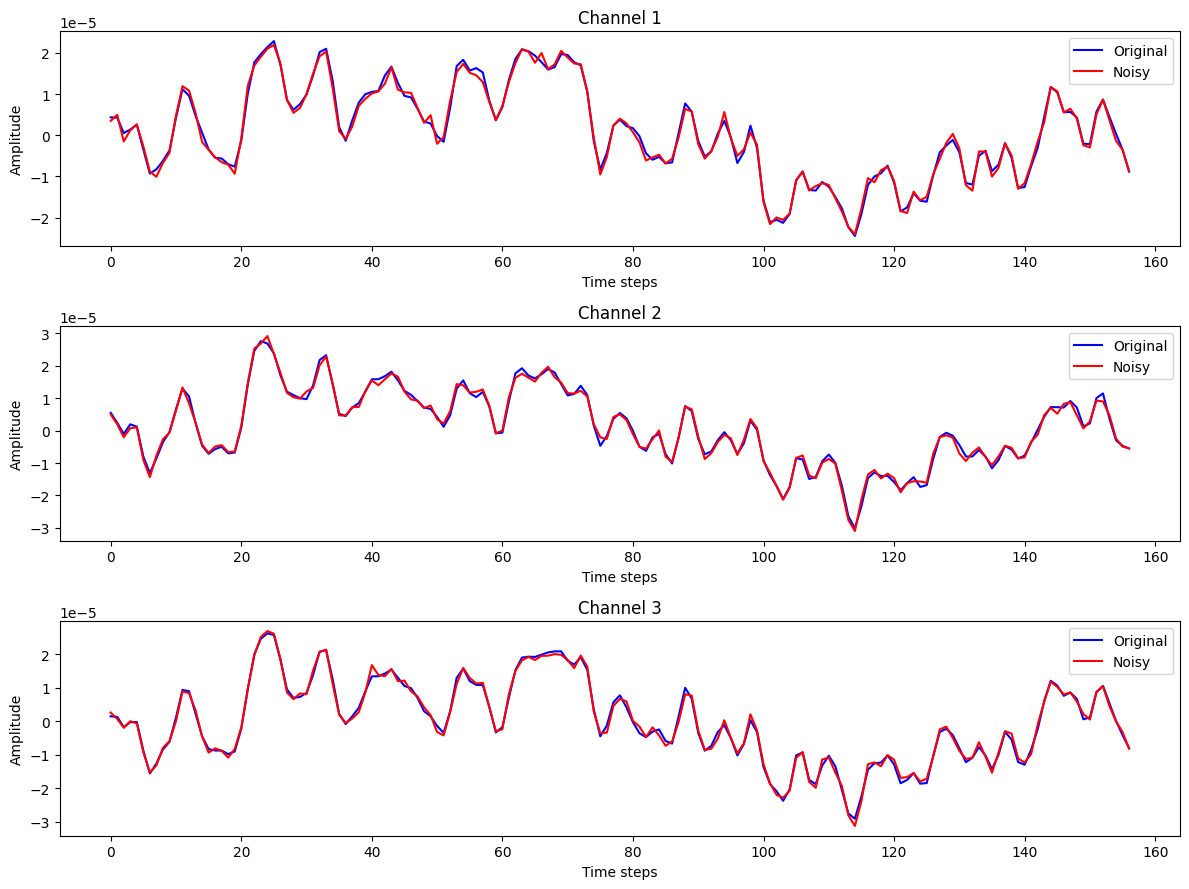

In [15]:
# Example usage:
# Assuming 'inputs', 'noisy_inputs', and 'denoised_outputs' are available
plot_eeg_time_series(inputs, noisy_inputs, denoised_data=None, channel_indices=[0, 1, 2], time_range=(100, 300))


In [16]:
# truths.shape

In [17]:
# Normalize data to range [0, 1] for consistency and to aid learning.
noisy_inputs = (noisy_inputs - np.min(noisy_inputs)) / (np.max(noisy_inputs) - np.min(noisy_inputs))
truths = (truths - np.min(truths)) / (np.max(truths) - np.min(truths))

In [18]:
# Split the data into training and testing sets to evaluate model performance.
x_train, x_test, y_train, y_test = train_test_split(noisy_inputs, truths, test_size=0.2, random_state=42)


In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4147, 257, 22)
(4147, 257, 22)
(1037, 257, 22)
(1037, 257, 22)


## Build CNN Autoencoder Model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape.

In [21]:
import keras
from keras import layers

In [59]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=22, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 257, 32)        │         4,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 257, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 257, 16)        │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_36             │ (None, 257, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 257, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_37             │ (None, 257, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_38             │ (None, 257, 22)        │         4,950 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,934 (73.96 KB)

 Trainable params: 18,934 (73.96 KB)

 Non-trainable params: 0 (0.00 B)

## Train CNN Autoencoder Model

In [60]:
x_train.shape

(4147, 257, 22)

In [61]:
y_train.shape

(4147, 257, 22)

In [62]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0610 - val_loss: 0.0023
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8026e-04 - val_loss: 0.0015
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8616e-04 - val_loss: 0.0021
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2741e-04 - val_loss: 0.0024
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0178e-04 - val_loss: 0.0021
Epoch 10/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4351e-04 - val_loss: 0.0018
Epoch 11/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9243e-04 - val_loss: 0.0016
Epoch 12/20
130/130 ━━━━━━━━

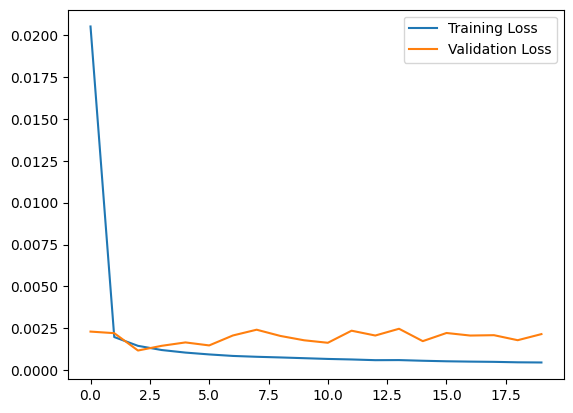

In [63]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Inference on test set

In [64]:
# Assuming 'model' is the trained Transformer model and 'x_test' is the test dataset

# Predict the outputs for the test set
predicted_outputs = model.predict(x_test)

# You can now use 'predicted_outputs' for further analysis, visualization, or post-processing
# For example, printing the shape of the outputs and some sample data
print("Shape of the predicted outputs:", predicted_outputs.shape)
# print("Sample predictions:", predicted_outputs[:5])

# If you need to compare these predictions with the actual labels
# Assuming 'y_test' contains the true values for the test set
# print("Actual true outputs:", y_train[:5])

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of the predicted outputs: (1037, 257, 22)


In [65]:


# # calculate the performance metrics, 'Mean Squared Error'
from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(y_train, predicted_outputs)
# print("Mean Squared Error on Test Set:", mse)


In [66]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate MSE for each feature (channel) and average over all time steps
# Adjusted for y_test and predicted_outputs having the shape (batch_size, sequence_length, num_features)
mse_per_feature = np.mean([mean_squared_error(y_test[:, :, i], predicted_outputs[:, :, i]) for i in range(y_test.shape[2])])
print("Mean Squared Error per feature, averaged over time steps:", mse_per_feature)


Mean Squared Error per feature, averaged over time steps: 0.002161154731425902


In [67]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize a numpy array to store the MSE values for each channel
# Adjust to reflect that the channels are now the last dimension
mse_per_channel = np.zeros((y_test.shape[2],))  # y_test.shape[2] is 22 if there are 22 channels

# Loop through each channel and calculate MSE
for channel_index in range(y_test.shape[2]):  # Loop over the last dimension
    # Extract the channel data for both true and predicted values
    true_channel_data = y_test[:, :, channel_index]
    predicted_channel_data = predicted_outputs[:, :, channel_index]

    # Compute the MSE for this channel
    mse_per_channel[channel_index] = mean_squared_error(true_channel_data, predicted_channel_data)

    # Optionally, print the MSE for each channel
    print(f"MSE for Channel {channel_index + 1}: {mse_per_channel[channel_index]}")


MSE for Channel 1: 0.00204180908268535
MSE for Channel 2: 0.0012680920384340042
MSE for Channel 3: 0.002998028071117827
MSE for Channel 4: 0.002926722855098586
MSE for Channel 5: 0.0022632625774841836
MSE for Channel 6: 0.0017126865051173294
MSE for Channel 7: 0.0022677598708380066
MSE for Channel 8: 0.0025472566963317
MSE for Channel 9: 0.0017895661082657389
MSE for Channel 10: 0.0016016038456596637
MSE for Channel 11: 0.001731781419240419
MSE for Channel 12: 0.0017089787166975137
MSE for Channel 13: 0.0017371287183773128
MSE for Channel 14: 0.0017040049799720526
MSE for Channel 15: 0.0017205482704925968
MSE for Channel 16: 0.0017217145093383235
MSE for Channel 17: 0.0017380631321876462
MSE for Channel 18: 0.001749692548205975
MSE for Channel 19: 0.0017564235041164023
MSE for Channel 20: 0.001755978666685712
MSE for Channel 21: 0.0017422260924756276
MSE for Channel 22: 0.0017172262279155942
MSE for Channel 23: 0.001747988299981232
MSE for Channel 24: 0.0017896042812882123
MSE for Chan

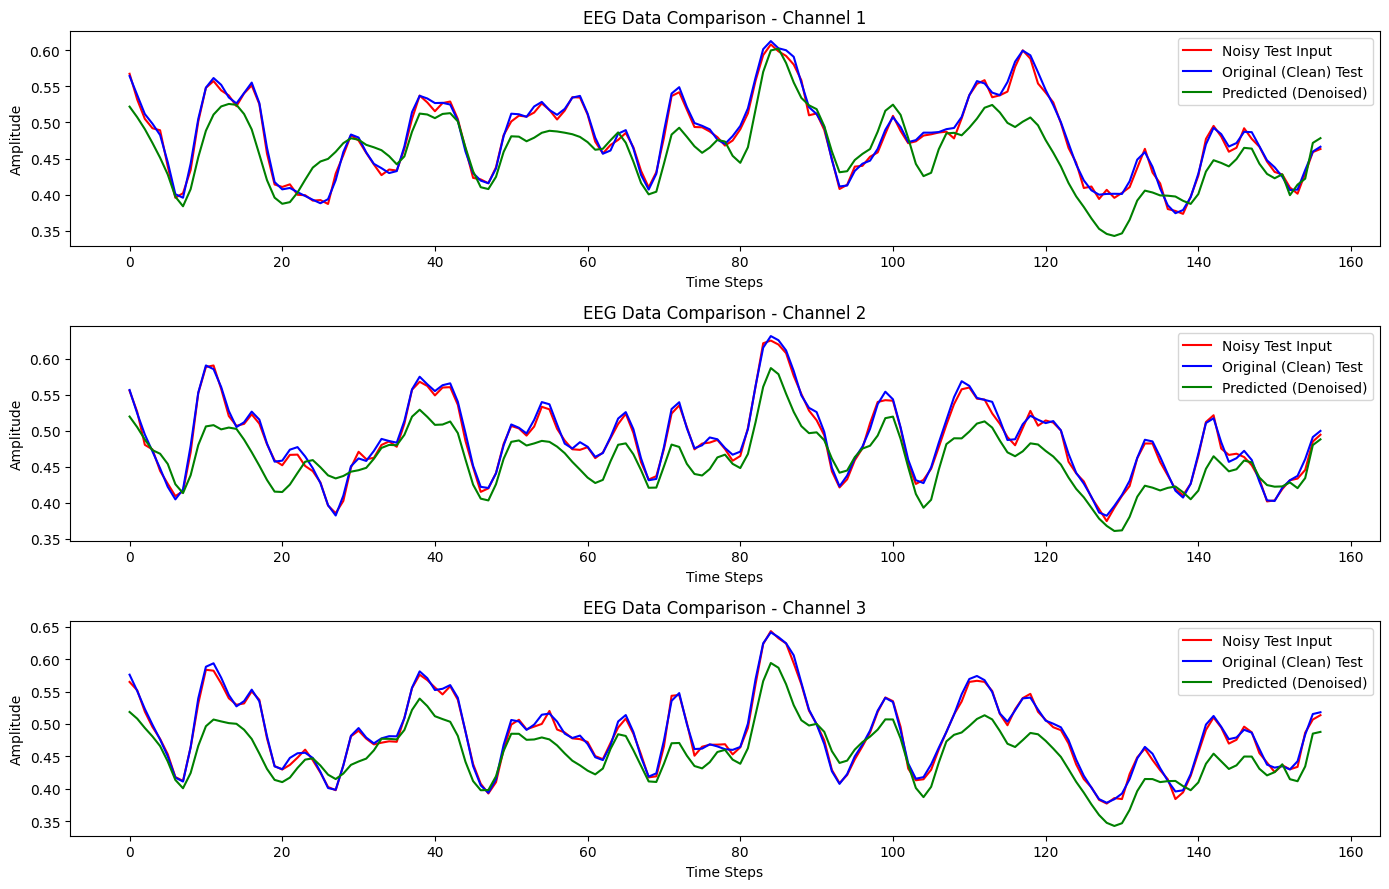

In [69]:
import matplotlib.pyplot as plt

def plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0], time_range=None, sample_index=0):
    """
    Plots comparison of EEG data for test input, test ground truth, and predicted outputs.

    Parameters:
    - x_test: numpy array of shape (batch_size, sequence_length, num_features), noisy EEG data used for testing.
    - y_test: numpy array of the same shape, original EEG data (ground truth for testing).
    - predicted_outputs: numpy array of the same shape, model's prediction on x_test.
    - channel_indices: list of integers, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot. Defaults to the full range.
    - sample_index: integer, index of the sample from the test set to plot.
    """
    # Define the time range to plot if not specified
    if time_range is None:
        time_range = (0, x_test.shape[1])  # Use the full range of time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), squeeze=False)
    
    # Iterate over each specified channel index
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot each dataset; update indexing to reflect the last dimension as channels
        ax.plot(x_test[sample_index, time_range[0]:time_range[1], channel_idx], label='Noisy Test Input', color='red')
        ax.plot(y_test[sample_index, time_range[0]:time_range[1], channel_idx], label='Original (Clean) Test', color='blue')
        ax.plot(predicted_outputs[sample_index, time_range[0]:time_range[1], channel_idx], label='Predicted (Denoised)', color='green')
        
        ax.set_title(f'EEG Data Comparison - Channel {channel_idx + 1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage of the function
# Assume x_test, y_test, and predicted_outputs are loaded with the correct shapes
plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0, 1, 2], time_range=(100, 300), sample_index=0)


To DO:
We plan to jointly train this Transformer Denoiser network with EEGNet using a joint Loss function: Reconstruction loss for Denoiser + BCE loss for classification. 

Training standalone Transformer on reconstruction task is not necessary unless to make sure it's working. Fine tuning model hyperparameters and architecture has to be performed jointly on Transformer(Denoiser) + EEGNet pipeline, with frozen weights for EEGNet. 

Immediate task: Train the EEGNet by running necessary scripts and save the model weights, as they are currently missing. 

Next, import the EEGNet model from python script as a library into the Transformer notebook, instantiate the model, load the weights, and make trainable=False to freeze the weights. 

Then, build the pipeline of Transformer + EEGNet and optimize(train) the Transformer model using the joint loss function. 

Finally, write this as a script.

Note: For Transformer architecture, you can use classical time encoding methods or use learning methods like time2vec with trainable weights

Note: You can either design the Denoiser as an offset producer (have a skip connection from input and subtract it with pre-final output to effectively output the offset requiret to Denoise EEG data. OR view the Denoiser as a signal enhancer that will produce a cleaner version of raw signal with only important features, removing irrelevant details.

**Tasks:**

Build Three types of Autoencoders: CNN, LSTM, Transformers, compare their performance (as a signal reconstruction prpoblem - denoinsing task) and present results in final paper. Continue using the best performing model in building end-to-end training pipeline along with EEGNet.

Note the number of trainable parameters also, in each model!